In [102]:
from utils.data_handling import *
from utils.sensor_optimisation import *
from parameters import *
import GPy
import scipy.stats
from sklearn.covariance import GraphicalLasso


import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

### Importing the Tracer Data to Select the Optimisation set S

In [103]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [104]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


### Working subset of the data : set S

In [105]:
S_human = human_level_subset(buildingshape, loc_df, 2,1 )
print("The remaining number of points is : ", str(len(S_human)))

The remaining number of points is :  37847


In [106]:
S_working = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 )
print("The remaining number of points is : ", str(len(S_working)))

The remaining number of points is :  57725


In [107]:
S = np.intersect1d(S_human,S_working)
print("The remaining number of points is : ", str(len(S)))

The remaining number of points is :  23643


### Import the Field of interest for computing the optimisation : TracerBackground / Pressure

In [160]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters


{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [161]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

  0%|          | 0/1 [00:00<?, ?it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [162]:
X = loc_df.values #[I,:dim]
Z = data_df.values#[:,t].reshape(-1,1) # [I,t].reshape(-1,1)
Z.shape

(100040, 989)

### Detrending Data : 
Plotting the data along each direction in order to see if there is a obvious trend. It seams that it is not the case. 

In [12]:
# Tracer Starting point
X_0 = X[np.unravel_index(Z.argmax(), Z.shape)[0],:]
X_0

array([-23.50261288,  25.09719562,  11.76448376])

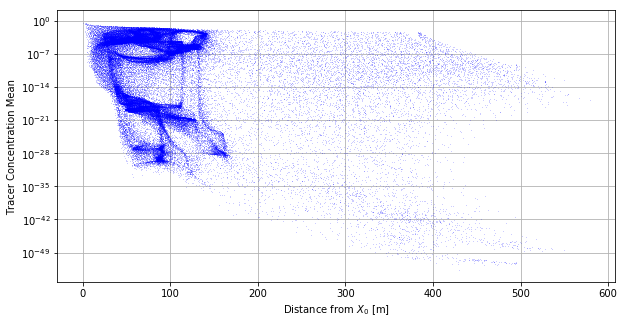

In [13]:
fig =plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_yscale('log')
#ax.set_xscale('log')
ax.plot(np.linalg.norm(X[:,:] - X_0,axis=1),Z[:,:].mean(axis=1),'o', c='blue', alpha=1, markeredgecolor='none',markersize=0.5)
plt.xlabel(r'Distance from $X_0$ [m]')
plt.ylabel(r'Tracer Concentration Mean')
plt.grid()


Temporal Analysis : 

In [14]:
# Threshold bellow which everything is zero : 
thresh = 0.000000000001

Text(0.5, 1.0, 'Percentage of points over $\\tau$ = 1e-12')

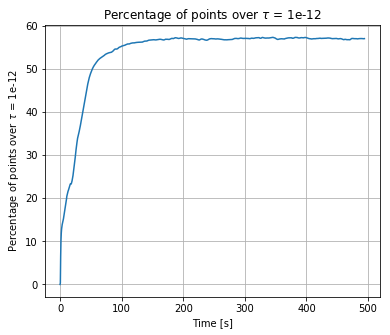

In [170]:
# plot of the non zero elements in function of the time 
plt.figure(figsize=(6,5))
plt.plot(time_df,100*np.sum(Z[:,:]>=thresh,axis=0)/Z.shape[0]);
plt.xlabel('Time [s]')
plt.ylabel(r'Percentage of points over $\tau$ = ' + str(thresh))
plt.grid()
plt.title(r'Percentage of points over $\tau$ = ' + str(thresh))


Text(0.5, 1.0, 'Percentage of points over $\\tau$ = 1e-12')

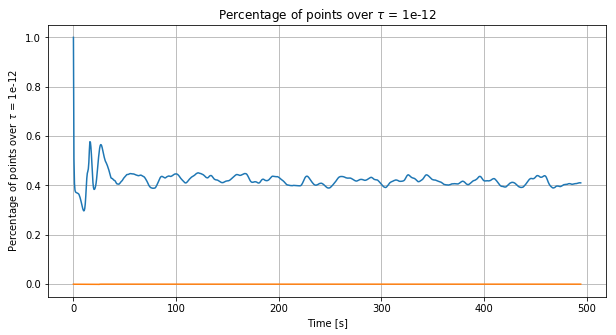

In [16]:
# plot of the non zero elements in function of the time 
plt.figure(figsize=(10,5))
plt.plot(time_df,np.max(Z[:,:],axis=0));
plt.plot(time_df,np.min(Z[:,:],axis=0));

plt.xlabel('Time [s]')
plt.ylabel(r'Percentage of points over $\tau$ = ' + str(thresh))
plt.grid()
plt.title(r'Percentage of points over $\tau$ = ' + str(thresh))


In [17]:
Z[S,:] = (Z[S,:] - Z[S,:].mean(axis=1,keepdims=True))

In [18]:
Z.shape

(100040, 989)

Plot of covariance in function of distance 

In [20]:
from sklearn.covariance import *


In [21]:
cov, shrinkage_coef = oas(Z[S,:].T)


In [79]:
i_0 = 3078#np.unravel_index(Z.argmax(), Z.shape)[0]
dist = (loc_df.loc[S,:]-loc_df.loc[i_0,:]).apply(np.linalg.norm,axis=1).values

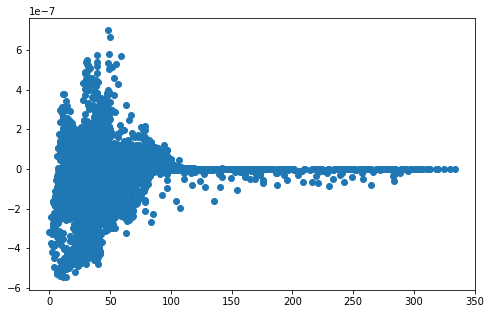

In [80]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax.set_yscale('linear')

ax.plot(dist,cov[i_0,:],'o')

In [81]:
np.unravel_index(Z.argmax(), Z.shape)[0]

9739

In [70]:
a = np.array([1]*10)
b = a.copy()
b[:2] = 0
b

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [71]:
a @ b

8

Z.shape

In [ ]:
Z_norm = (Z - Z.mean(axis=1,keepdims=True))

In [154]:
Z[0,:] - np.mean(Z[0,:])

array([-2.93246299e+00,  4.16757663e+01,  4.53000791e+01,  4.20345236e+01,
        3.18254010e+01,  8.73828792e+00, -5.24024297e+00, -1.02942611e+01,
       -2.79976621e+01, -3.59033568e+01, -5.12542458e+01, -4.58535325e+01,
       -2.73788877e+01, -2.46190414e+01, -1.75531290e+01, -8.86239715e+00,
       -6.54846225e+00,  8.04836906e+00,  4.34129031e+00,  8.18817848e+00,
        6.94066890e+00, -2.05417342e+00,  4.42594747e+00,  1.66726361e+01,
        4.83635018e+00,  7.30249054e-01, -8.45432012e+00, -8.77720708e+00,
       -1.26446353e+01, -2.61936891e+01, -4.18635098e+01, -2.61951004e+01,
       -1.27401975e+01, -4.98417305e+00,  1.93533812e+01,  3.54452941e+01,
        5.48575795e+01,  6.28742966e+01,  5.08886772e+01,  3.74513981e+01,
        1.73200489e+01, -9.57502520e+00, -2.95973558e+01, -4.25764642e+01,
       -5.26066239e+01, -5.24307959e+01, -5.16950803e+01, -3.27832137e+01,
       -2.30528241e+01, -2.27857063e+01, -2.41431716e+01, -1.77359000e+01,
       -2.93956944e+00,  

In [163]:
Z_std = (Z - Z.mean(axis=1,keepdims=True))/ Z.std(axis=1,keepdims=True)

In [121]:
I = np.linspace(0,1)
Normal = scipy.stats.norm.pdf(I)*10**8

Text(0.5, 1.0, 'Histogram of Standardized Tracer Concentration')

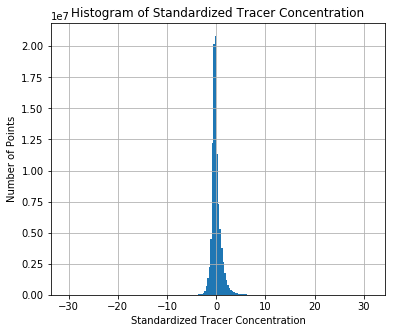

In [171]:
fig = plt.figure(figsize=(6,5))
ax = fig.gca()
#ax.set_yscale('log')
ax.hist(Z_std[:,:].flatten(),bins=200);
#plt.plot(I,Normal);
plt.xlabel('Standardized Tracer Concentration')
plt.ylabel('Number of Points')
plt.grid()
plt.title('Histogram of Standardized Tracer Concentration')

array([39894228.04014327, 39885921.0692123 , 39861010.53328704,
       39819527.54136922, 39761523.86985393, 39687071.85483798,
       39596264.24179094, 39489213.99302611, 39366054.05353087,
       39226937.07583608, 39072035.10472128, 38901539.22266743,
       38715659.15707995, 38514622.85041198, 38298675.99442122,
       38068081.52989237, 37823119.11325056, 37564084.55158019,
       37291289.20764624, 37005059.37659235, 36705735.63606135,
       36393672.17154837, 36069236.07885545, 35732806.64556814,
       35384774.61351925, 35025541.42424361, 34655518.44945811,
       34275126.20862568, 33884793.57567876, 33484956.97698778,
       33076059.58266303, 32658550.49327426, 32232883.92406157,
       31799518.38869339, 31358915.88460332, 30911541.08190665,
       30457860.51786095, 29998341.79879206, 29533452.81135798,
       29063660.94496953, 28589432.32712695, 28111231.07336745,
       27629518.55345008, 27144752.67533069, 26657387.18840336,
       26167871.00740331, 25676647.55828

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])